In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

Index(['Symbol', 'AtomicMass', 'AtomicRadius', 'Electronegativity',
       'IonizationEnergy', 'ElectronAffinity', 'Polarizability',
       'results_per_total', 'results_per_li', 'LiSites', 'CounterIonSites',
       'results_per_counter_ion', 'Result'],
      dtype='object')


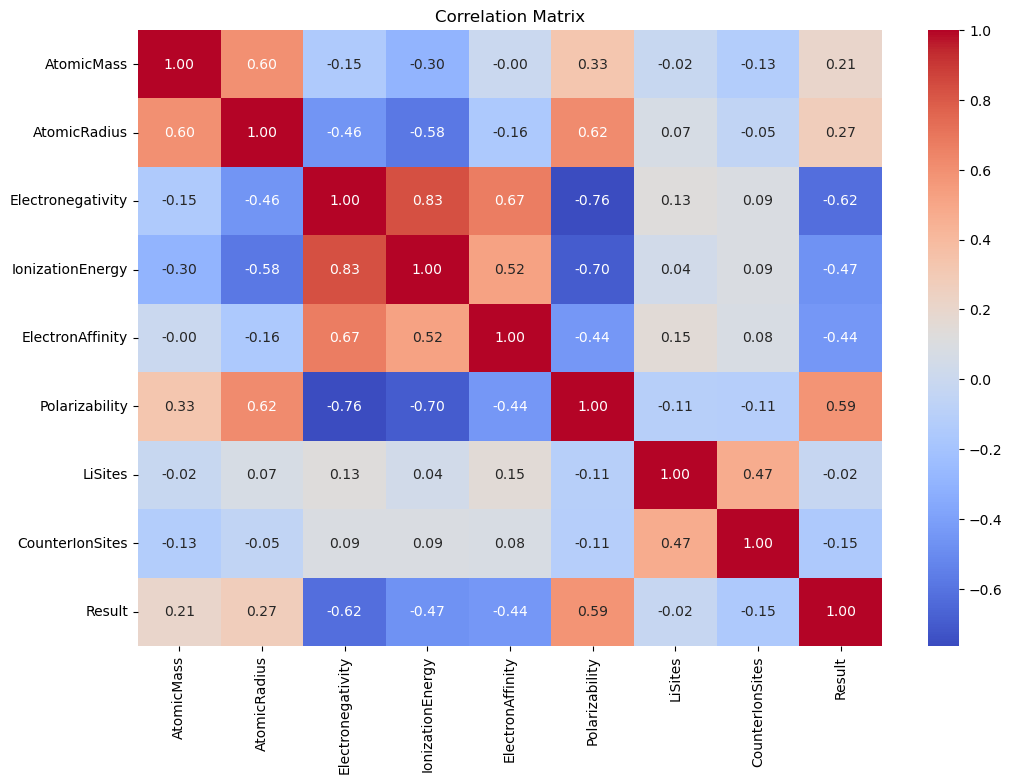

In [65]:
df = pd.read_csv('all_props.csv')

X = df.drop(columns=['results_per_li','results_per_total','Symbol','results_per_counter_ion'])
print(df.columns)
Y_total = df['results_per_total']
Y_li = df['results_per_li']


X.corr()

#plot X 

plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


#### reducing dimentinallity 

In [66]:
df.drop(columns=['Result'], inplace=True)

X = df.drop(columns=['results_per_li','results_per_total','Symbol','results_per_counter_ion'])

In [67]:
X

,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,LiSites,CounterIonSites
0,69.72300,187,1.81,5.999,0.300,50.00,1,3
1,63.55000,140,1.90,7.726,1.228,46.50,2,6
2,107.86800,172,1.93,7.576,1.302,55.00,1,1
3,106.42000,202,2.20,8.337,0.557,26.14,3,1
4,114.81800,193,1.78,5.786,0.300,65.00,3,1
...,...,...,...,...,...,...,...,...
447,204.38300,196,1.62,6.108,0.200,66.00,1,3
448,144.91276,236,0.00,5.550,0.000,200.00,1,3
449,24.30500,173,1.31,7.646,0.000,71.20,1,149
450,195.08000,209,2.28,9.000,2.128,48.00,3,1


In [68]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y_total, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Compute MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # MAPE in percentage

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Get feature importance (coefficients for linear regression)
features = X.columns  # Feature names
coefficients = model.coef_

# Combine into a dictionary
importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}

# Sort by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print feature importances (coefficients)

i=0
print("\nFeature Importances (Coefficients):")
for feature, coef in sorted_importances:
    print(f"{feature}: {coef:.4f}")
    i+=1
    if i>10:
        break


Mean Absolute Percentage Error (MAPE): 76.33%

Feature Importances (Coefficients):
Electronegativity: -0.0052
ElectronAffinity: -0.0008
IonizationEnergy: 0.0005
LiSites: 0.0001
CounterIonSites: -0.0001
AtomicRadius: -0.0001
Polarizability: 0.0000
AtomicMass: 0.0000


#### Polynomial regression with grid search cv

In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
import numpy as np

# Custom scorer for MAPE (lower is better)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y_total, test_size=0.2, random_state=42)

# Try different degrees
best_score = float('inf')
best_degree = None

for degree in range(1, 6):  # Trying degrees 1 to 5
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    # Negative because cross_val_score by default maximizes score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mape_scorer)
    avg_mape = -np.mean(scores) * 100  # Convert back to positive percentage

    print(f"Degree {degree}: Avg CV MAPE = {avg_mape:.2f}%")

    if avg_mape < best_score:
        best_score = avg_mape
        best_degree = degree

print(f"\nBest Degree: {best_degree} with Avg CV MAPE: {best_score:.2f}%")

# Train final model with best degree
final_poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = final_poly.fit_transform(X_train)
X_test_poly = final_poly.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train_poly, y_train)

# Predict
y_pred = final_model.predict(X_test_poly)

# Compute final test MAPE
final_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"\nFinal Test Mean Absolute Percentage Error (MAPE): {final_mape:.2f}%")

# Feature importance
features = final_poly.get_feature_names_out(X.columns)
coefficients = final_model.coef_

importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print top 10 features
i = 0
print("\nFeature Importances (Coefficients):")
for feature, coef in sorted_importances:
    print(f"{feature}: {coef:.4f}")
    i += 1
    if i > 10:
        break


Degree 1: Avg CV MAPE = 128.91%
Degree 2: Avg CV MAPE = 122.09%
Degree 3: Avg CV MAPE = 2399410.77%
Degree 4: Avg CV MAPE = 2779134.92%
Degree 5: Avg CV MAPE = 2307549.29%

Best Degree: 2 with Avg CV MAPE: 122.09%

Final Test Mean Absolute Percentage Error (MAPE): 66.02%

Feature Importances (Coefficients):
Electronegativity: 0.0630
ElectronAffinity: -0.0311
IonizationEnergy: -0.0252
Electronegativity ElectronAffinity: 0.0080
Electronegativity^2: -0.0057
LiSites: 0.0036
ElectronAffinity^2: -0.0021
AtomicRadius: -0.0016
Electronegativity IonizationEnergy: -0.0010
Electronegativity LiSites: 0.0006
Polarizability: 0.0005


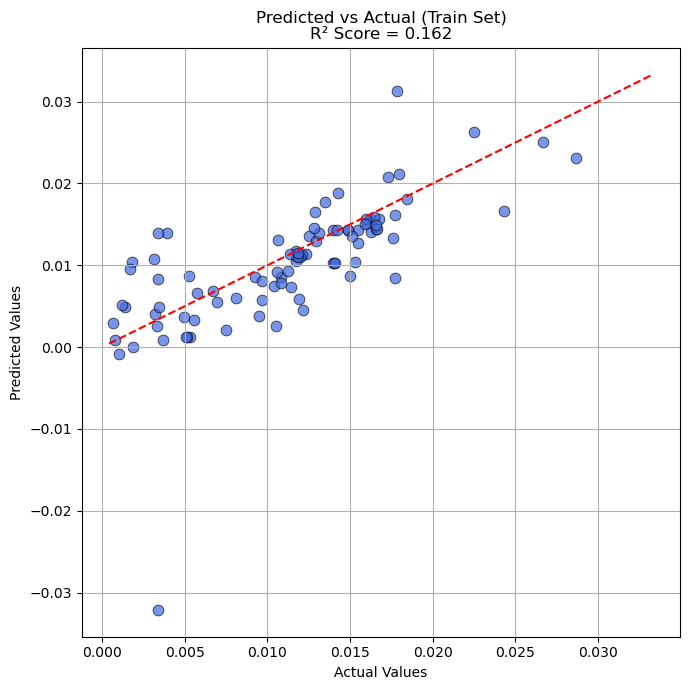

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# If you've already done model.predict(X_train)
y_test_pred = final_model.predict(X_test_poly)

# Plot actual vs predicted
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_test_pred, color='royalblue', s=60, edgecolor='black', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs Actual (Train Set)\nR² Score = {r2_score(y_test, y_test_pred):.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
# Get intercept (β0)
intercept = final_model.intercept_

# Get coefficients (β1, β2, ..., βn)
coefficients = final_model.coef_

# Get feature names from the PolynomialFeatures object
features = final_poly.get_feature_names_out(X.columns)  # Or from pipeline.named_steps['poly']

# Construct the equation
equation = f"y = {intercept:.4f}"
for feature, coef in zip(features, coefficients):
    equation += f" + ({coef:.4f} * {feature})"

print("Regression Equation:")
print(equation)

Regression Equation:
y = 0.1934 + (0.0002 * AtomicMass) + (-0.0016 * AtomicRadius) + (0.0630 * Electronegativity) + (-0.0252 * IonizationEnergy) + (-0.0311 * ElectronAffinity) + (0.0005 * Polarizability) + (0.0036 * LiSites) + (-0.0004 * CounterIonSites) + (-0.0000 * AtomicMass^2) + (0.0000 * AtomicMass AtomicRadius) + (0.0000 * AtomicMass Electronegativity) + (-0.0000 * AtomicMass IonizationEnergy) + (0.0000 * AtomicMass ElectronAffinity) + (-0.0000 * AtomicMass Polarizability) + (-0.0000 * AtomicMass LiSites) + (-0.0000 * AtomicMass CounterIonSites) + (0.0000 * AtomicRadius^2) + (-0.0002 * AtomicRadius Electronegativity) + (0.0001 * AtomicRadius IonizationEnergy) + (0.0000 * AtomicRadius ElectronAffinity) + (-0.0000 * AtomicRadius Polarizability) + (-0.0000 * AtomicRadius LiSites) + (0.0000 * AtomicRadius CounterIonSites) + (-0.0057 * Electronegativity^2) + (-0.0010 * Electronegativity IonizationEnergy) + (0.0080 * Electronegativity ElectronAffinity) + (-0.0000 * Electronegativity Po